**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Load data](#toc2_)    
- [Check for mixed types](#toc3_)    
- [Overview](#toc4_)    
  - [Descriptive statisitcs](#toc4_1_)    
  - [Missing values](#toc4_2_)    
  - [Duplicates](#toc4_3_)    
- [Remove non-printable characters from text features](#toc5_)    
- [Initial Data Audit](#toc6_)    
- [Fill in missing values](#toc7_)    
- [Feature Engineer](#toc8_)    
  - [`create_launch_hours` & `create_launch_hours_log`](#toc8_1_)    
  - [`create_deadline_hours` & `create_deadline_hours_log`](#toc8_2_)    
  - [`launched_deadline_hours`](#toc8_3_)    
- [Capitalize column names](#toc9_)    
- [Check target frequencies](#toc10_)    
- [Train-val-test split](#toc11_)    
- [Saving to files](#toc12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports](#toc0_)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from controller import Controller

from data_audit import DataAudit

In [18]:
c = Controller('i01')

# <a id='toc2_'></a>[Load data](#toc0_)

In [19]:
datecols = ['deadline', 'state_changed_at', 'created_at', 'launched_at']

df_development = pd.read_csv(fr'{c.get_path_data_original()}/train.csv')
df_oot = pd.read_csv(fr'{c.get_path_data_original()}/test.csv')

df_development[datecols] = df_development[datecols].apply(lambda x: pd.to_datetime(x, unit='s'))
df_oot[datecols] = df_oot[datecols].apply(lambda x: pd.to_datetime(x, unit='s'))

print(f'{df_development.shape=}')
print(f'{df_oot.shape=}')

df_development.shape=(108129, 14)
df_oot.shape=(63465, 12)


# <a id='toc3_'></a>[Check for mixed types](#toc0_)

In [20]:
can_be_numeric = []

for col in df_development.select_dtypes(exclude='number'):
    try:
        pd.to_numeric(df_development[col])
    except ValueError:
        pass
    else:
        can_be_numeric.append(col)

# We are left with the date columns which is ok.
can_be_numeric

['disable_communication',
 'deadline',
 'state_changed_at',
 'created_at',
 'launched_at']

# <a id='toc4_'></a>[Overview](#toc0_)

## <a id='toc4_1_'></a>[Descriptive statisitcs](#toc0_)

In [21]:
df_development.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
project_id,108129,108129,kkst1451568084,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,108126,107838,New EP/Music Development,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
desc,108120,107377,The Decentralized Dance Party was founded on t...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goal,108129.0,NaN,NaN,NaN,36726.228833,0.01,2000.0,5000.0,13000.0,100000000.0,971902.705156
keywords,108129,108129,drawing-for-dollars,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disable_communication,108129,2,False,107806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,108129,11,US,92033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
currency,108129,9,USD,92033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deadline,108129,NaN,NaN,NaN,2013-09-27 02:21:38.004855552,2009-05-03 06:59:59,2012-09-04 04:19:48,2014-02-28 23:00:00,2014-11-11 15:20:01,2015-05-31 18:28:58,NaN
state_changed_at,108129,NaN,NaN,NaN,2013-09-25 23:49:55.769811968,2009-05-03 07:00:17,2012-09-03 18:02:15,2014-02-28 06:00:18,2014-11-09 15:42:46,2015-05-31 18:29:00,NaN


## <a id='toc4_2_'></a>[Missing values](#toc0_)

In [22]:
df_development.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108129 entries, 0 to 108128
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   project_id             108129 non-null  object        
 1   name                   108126 non-null  object        
 2   desc                   108120 non-null  object        
 3   goal                   108129 non-null  float64       
 4   keywords               108129 non-null  object        
 5   disable_communication  108129 non-null  bool          
 6   country                108129 non-null  object        
 7   currency               108129 non-null  object        
 8   deadline               108129 non-null  datetime64[ns]
 9   state_changed_at       108129 non-null  datetime64[ns]
 10  created_at             108129 non-null  datetime64[ns]
 11  launched_at            108129 non-null  datetime64[ns]
 12  backers_count          108129 non-null  int6

In [23]:
# 1. "final_status" is the target variable.
# 2. "backers_count" is missing from the OOT set. This means we shouldn't train the model on it.
df_oot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63465 entries, 0 to 63464
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   project_id             63465 non-null  object        
 1   name                   63465 non-null  object        
 2   desc                   63461 non-null  object        
 3   goal                   63465 non-null  float64       
 4   keywords               63465 non-null  object        
 5   disable_communication  63465 non-null  bool          
 6   country                63465 non-null  object        
 7   currency               63465 non-null  object        
 8   deadline               63465 non-null  datetime64[ns]
 9   state_changed_at       63465 non-null  datetime64[ns]
 10  created_at             63465 non-null  datetime64[ns]
 11  launched_at            63465 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](4), float64(1), object(6)
memory 

## <a id='toc4_3_'></a>[Duplicates](#toc0_)

In [24]:
# `False` means no duplicates
any(df_development.duplicated())

False

# <a id='toc5_'></a>[Remove non-printable characters from text features](#toc0_)

In [25]:
# https://stackoverflow.com/questions/36340627/remove-non-ascii-characters-from-pandas-column

dfs = [df_development, df_oot]
for i in range(len(dfs)):
    text_features = dfs[i].select_dtypes('object').columns

    del_chars =  " ".join([chr(i) for i in list(range(32)) + list(range(127, 256))])
    trans = str.maketrans(del_chars, " " * len(del_chars))

    dfs[i][text_features] = dfs[i][text_features].apply(lambda s: s.str.translate(trans))
    dfs[i][text_features]

df_development

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,2009-05-03 06:59:59,2009-05-03 07:00:17,2009-04-24 19:15:07,2009-04-24 19:52:03,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,2009-05-15 23:10:00,2009-05-16 00:00:18,2009-04-28 23:10:24,2009-04-29 03:26:32,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,2009-05-22 21:26:00,2009-05-22 21:30:18,2009-05-12 21:26:53,2009-05-12 21:39:58,0,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,2009-05-29 00:09:00,2009-05-29 00:15:21,2009-04-29 00:09:55,2009-04-29 00:58:50,18,1
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,2009-05-31 11:38:00,2009-05-31 11:45:17,2009-05-01 11:38:34,2009-05-01 12:22:21,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108124,kkst542772509,Custom Wearable Art,Sacred geometry art and custom clothing. Embro...,2000.0,custom-wearable-art,False,US,USD,2015-05-31 18:07:31,2015-05-31 18:07:34,2015-04-18 18:38:27,2015-05-01 18:07:31,3,0
108125,kkst615785942,Painted Modern Wall art Mid-century! $100 for...,I want to create pieces very similar to this o...,15000.0,zacharys-art-project,False,US,USD,2015-05-31 18:14:00,2015-05-31 18:14:01,2015-04-06 17:05:09,2015-04-06 18:14:54,1,0
108126,kkst1421442073,Creating High Quality Art Prints from the Arti...,I am seeking to produce prints to promote my r...,320.0,creating-high-quality-art-prints-from-the-arti...,False,US,USD,2015-05-31 18:18:54,2015-05-31 18:18:57,2015-04-30 19:02:44,2015-05-01 18:18:54,11,1
108127,kkst2022543055,back to basics,A self sustaining homestead with organic produ...,35000.0,back-to-basics-2,False,US,USD,2015-05-31 18:23:00,2015-05-31 18:23:04,2015-04-26 18:23:14,2015-04-30 19:22:07,0,0


# <a id='toc6_'></a>[Initial Data Audit](#toc0_)

In [26]:
data_audit_full = DataAudit()
data_audit_full.fit(df_development)
data_audit_full.view_summary()

100%|██████████| 14/14 [00:03<00:00,  4.24it/s, Processing final_status]        


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,project_id,.,object,1.0000,0.0000,NaN,<NA>,NaN,NaN,NaN,.
1,name,.,object,0.9973,0.0000,NaN,<NA>,NaN,NaN,NaN,.
2,desc,.,object,0.9931,0.0001,NaN,<NA>,NaN,NaN,NaN,.
3,goal,.,float64,0.0330,0.0000,36726.228833,971902.705156,0.01,5000.0,100000000.0,.
4,keywords,.,object,1.0000,0.0000,NaN,<NA>,NaN,NaN,NaN,.
5,disable_communication,.,bool,0.0000,0.0000,NaN,<NA>,NaN,NaN,NaN,.
6,country,.,object,0.0001,0.0000,NaN,<NA>,NaN,NaN,NaN,.
7,currency,.,object,0.0001,0.0000,NaN,<NA>,NaN,NaN,NaN,.
8,deadline,.,datetime64[ns],0.9334,0.0000,2013-09-27 02:21:38.004855552,<NA>,2009-05-03 06:59:59,2014-02-28 23:00:00,2015-05-31 18:28:58,.
9,state_changed_at,.,datetime64[ns],0.9472,0.0000,2013-09-25 23:49:55.769811968,<NA>,2009-05-03 07:00:17,2014-02-28 06:00:18,2015-05-31 18:29:00,.


# <a id='toc7_'></a>[Fill in missing values](#toc0_)

In [27]:
features_with_missing = ['desc', 'name']
df_development[features_with_missing] = df_development[features_with_missing].fillna('""')
pd.concat([
    df_development.isna().sum().sort_values(ascending=False),
    df_development.isna().mean(),
], axis=1, keys=['# Missing', '% Missing'])

,# Missing,% Missing
project_id,0,0.0
name,0,0.0
desc,0,0.0
goal,0,0.0
keywords,0,0.0
disable_communication,0,0.0
country,0,0.0
currency,0,0.0
deadline,0,0.0
state_changed_at,0,0.0


In [28]:
df_oot.isna().sum()

project_id               0
name                     0
desc                     4
goal                     0
keywords                 0
disable_communication    0
country                  0
currency                 0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
dtype: int64

In [29]:
df_oot = df_oot.fillna('""')
df_oot.isna().sum()

project_id               0
name                     0
desc                     0
goal                     0
keywords                 0
disable_communication    0
country                  0
currency                 0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
dtype: int64

# <a id='toc8_'></a>[Feature Engineer](#toc0_)

In [30]:
df_development.select_dtypes('datetime')

,deadline,state_changed_at,created_at,launched_at
0,2009-05-03 06:59:59,2009-05-03 07:00:17,2009-04-24 19:15:07,2009-04-24 19:52:03
1,2009-05-15 23:10:00,2009-05-16 00:00:18,2009-04-28 23:10:24,2009-04-29 03:26:32
2,2009-05-22 21:26:00,2009-05-22 21:30:18,2009-05-12 21:26:53,2009-05-12 21:39:58
3,2009-05-29 00:09:00,2009-05-29 00:15:21,2009-04-29 00:09:55,2009-04-29 00:58:50
4,2009-05-31 11:38:00,2009-05-31 11:45:17,2009-05-01 11:38:34,2009-05-01 12:22:21
...,...,...,...,...
108124,2015-05-31 18:07:31,2015-05-31 18:07:34,2015-04-18 18:38:27,2015-05-01 18:07:31
108125,2015-05-31 18:14:00,2015-05-31 18:14:01,2015-04-06 17:05:09,2015-04-06 18:14:54
108126,2015-05-31 18:18:54,2015-05-31 18:18:57,2015-04-30 19:02:44,2015-05-01 18:18:54
108127,2015-05-31 18:23:00,2015-05-31 18:23:04,2015-04-26 18:23:14,2015-04-30 19:22:07


## <a id='toc8_1_'></a>[`create_launch_hours` & `create_launch_hours_log`](#toc0_)

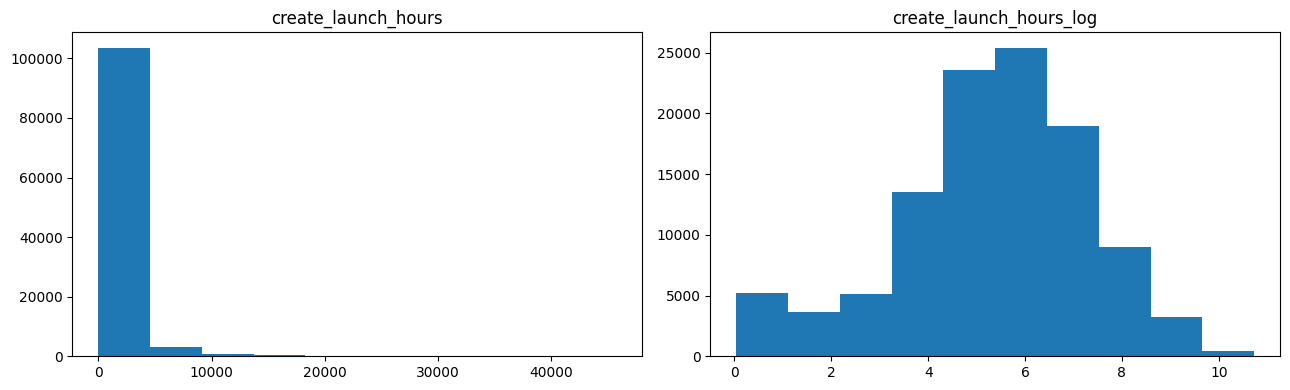

In [31]:
df_development['create_launch_hours'] = (df_development['launched_at'] - df_development['created_at']).dt.total_seconds() / 3600
df_development['create_launch_hours_log'] = np.log1p(df_development['create_launch_hours'])

df_oot['create_launch_hours'] = (df_oot['launched_at'] - df_oot['created_at']).dt.total_seconds() / 3600
df_oot['create_launch_hours_log'] = np.log1p(df_oot['create_launch_hours'])

_, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df_development['create_launch_hours'])
axes[0].set_title('create_launch_hours')

axes[1].hist(df_development['create_launch_hours_log'])
axes[1].set_title('create_launch_hours_log')

plt.tight_layout()
plt.show()

## <a id='toc8_2_'></a>[`create_deadline_hours` & `create_deadline_hours_log`](#toc0_)

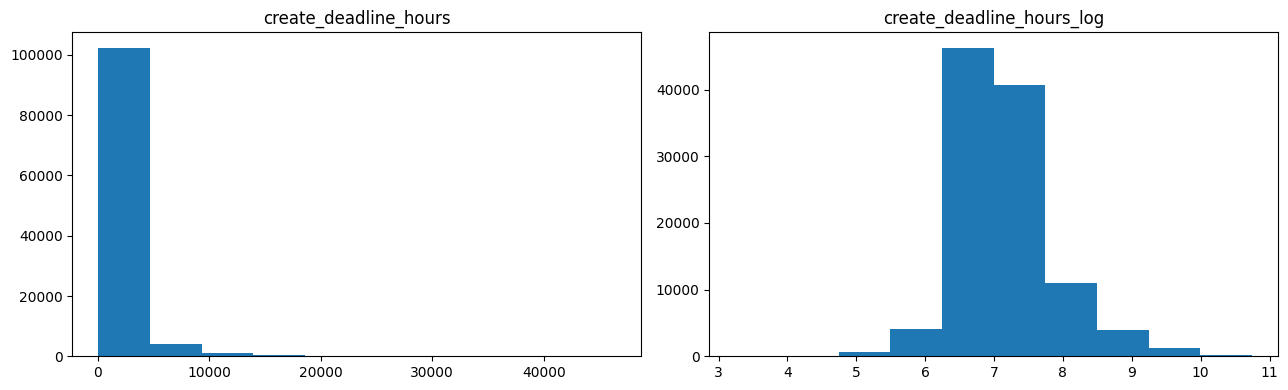

In [32]:
df_development['create_deadline_hours'] = (df_development['deadline'] - df_development['created_at']).dt.total_seconds() / 3600
df_development['create_deadline_hours_log'] = np.log1p(df_development['create_deadline_hours'])

df_oot['create_deadline_hours'] = (df_oot['deadline'] - df_oot['created_at']).dt.total_seconds() / 3600
df_oot['create_deadline_hours_log'] = np.log1p(df_oot['create_deadline_hours'])

_, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df_development['create_deadline_hours'])
axes[0].set_title('create_deadline_hours')

axes[1].hist(df_development['create_deadline_hours_log'])
axes[1].set_title('create_deadline_hours_log')

plt.tight_layout()
plt.show()

## <a id='toc8_3_'></a>[`launched_deadline_hours`](#toc0_)

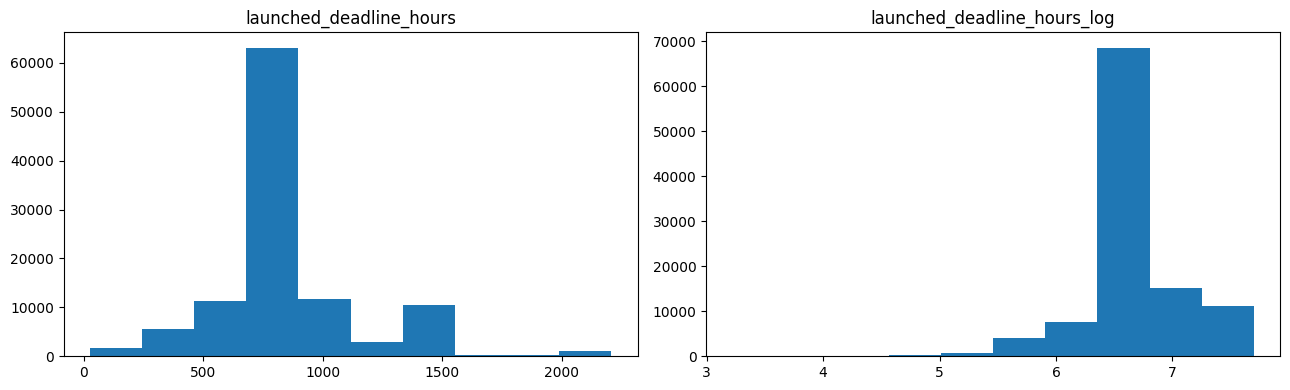

In [33]:
df_development['launched_deadline_hours'] = (df_development['deadline'] - df_development['launched_at']).dt.total_seconds() / 3600
df_oot['launched_deadline_hours'] = (df_oot['deadline'] - df_oot['launched_at']).dt.total_seconds() / 3600

_, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df_development['launched_deadline_hours'])
axes[0].set_title('launched_deadline_hours')

axes[1].hist(np.log1p(df_development['launched_deadline_hours']))
axes[1].set_title('launched_deadline_hours_log')

plt.tight_layout()
plt.show()

# <a id='toc9_'></a>[Capitalize column names](#toc0_)

In [34]:
df_oot.columns = df_oot.columns.map(lambda col: col.upper())
df_development.columns = df_development.columns.map(lambda col: col.upper())
df_development.columns

Index(['PROJECT_ID', 'NAME', 'DESC', 'GOAL', 'KEYWORDS',
       'DISABLE_COMMUNICATION', 'COUNTRY', 'CURRENCY', 'DEADLINE',
       'STATE_CHANGED_AT', 'CREATED_AT', 'LAUNCHED_AT', 'BACKERS_COUNT',
       'FINAL_STATUS', 'CREATE_LAUNCH_HOURS', 'CREATE_LAUNCH_HOURS_LOG',
       'CREATE_DEADLINE_HOURS', 'CREATE_DEADLINE_HOURS_LOG',
       'LAUNCHED_DEADLINE_HOURS'],
      dtype='object')

# <a id='toc10_'></a>[Check target frequencies](#toc0_)

In [35]:
column = 'FINAL_STATUS'
pd.concat([
    df_development[column].value_counts(dropna=False),
    df_development[column].value_counts(dropna=False, normalize=True),
], axis=1, keys=['Total #', 'Total %'])

,Total #,Total %
0,73568,0.680373
1,34561,0.319627


# <a id='toc11_'></a>[Train-val-test split](#toc0_)

In [36]:
df_train, df_val_test = train_test_split(df_development, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42)

print(f'{df_train.shape=}')
print(f'{df_val.shape=}')
print(f'{df_test.shape=}')

df_train['TRAIN_VAL_TEST_SPLIT'] = 'Train'
df_val['TRAIN_VAL_TEST_SPLIT'] = 'Validation'
df_test['TRAIN_VAL_TEST_SPLIT'] = 'Test'

df_development = pd.concat([df_train, df_val, df_test], ignore_index=True)

pd.concat([
    df_development['TRAIN_VAL_TEST_SPLIT'].value_counts(dropna=False),
    df_development['TRAIN_VAL_TEST_SPLIT'].value_counts(dropna=False, normalize=True),
], axis=1, keys=['Total #', 'Total %'])

df_train.shape=(86503, 19)
df_val.shape=(10813, 19)
df_test.shape=(10813, 19)


,Total #,Total %
Train,86503,0.799998
Validation,10813,0.100001
Test,10813,0.100001


# <a id='toc12_'></a>[Saving to files](#toc0_)

In [37]:
filepath = f'{c.get_path_iteration()}/data_audit_full.xlsx'
data_audit_full.export(filepath)

14it [03:24, 14.57s/it, Exporting final_status]        


In [ ]:
filepath = fr'{c.get_path_data_prepared()}/01_df_development.pkl'
df_development.to_pickle(filepath)

In [ ]:
filepath = fr'{c.get_path_data_prepared()}/01_df_oot.pkl'
df_oot.to_pickle(filepath)